In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
complete_data = pd.read_csv("EnergiaData.csv")
grouped_data = complete_data.groupby("AnonymisedMPRN").mean().iloc[:, 1:]
data_by_MPRN = grouped_data.copy()
time_interval_columns = grouped_data.columns

C:\Users\daniy\AppData\Local\Temp\ipykernel_10064\3648659894.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = complete_data.groupby("AnonymisedMPRN").mean().iloc[:, 1:]


In [3]:
def capOutliers(data, cap_threshold):
    """
    Caps outliers in the dataset based on a specified threshold.

    This function caps values in the dataset that are considered outliers, using a threshold defined by the number of 
    standard deviations from the mean. Any value greater than the mean plus the threshold times the standard deviation 
    is capped to this upper limit, and any value lower than the mean minus the threshold times the standard deviation 
    is capped to this lower limit.

    Parameters:
    - data (DataFrame or Series): The dataset containing numerical data. It can be a pandas DataFrame or Series.
    - cap_threshold (float): The threshold multiplier for capping outliers. Values beyond `mean ± cap_threshold * std` 
      are capped.

    Returns:
    - DataFrame or Series: The dataset with outliers capped according to the specified threshold.
    """
    # Apply capping
    return data.apply(lambda x: np.where(x > x.mean() + cap_threshold * x.std(), 
                                                                   x.mean() + cap_threshold * x.std(),
                                                                   np.where(x < x.mean() - cap_threshold * x.std(), 
                                                                            x.mean() - cap_threshold * x.std(), x)))

In [4]:
data_capped = capOutliers(data_by_MPRN[time_interval_columns], 3)

In [5]:
def scaleData(data):
    """
    Scales the dataset using standardization.

    This function standardizes the input dataset by removing the mean and scaling to unit variance.
    Standardization is done using `StandardScaler` from scikit-learn, which transforms each feature 
    so that it has a mean of 0 and a standard deviation of 1.

    Parameters:
    - data (array-like or DataFrame): The dataset to be standardized, typically a 2D array (e.g., DataFrame) 
      where rows represent samples and columns represent features.

    Returns:
    - ndarray: The standardized dataset as a NumPy array, where each feature has a mean of 0 and a standard deviation of 1.
    """
    scaler = StandardScaler()
    return scaler.fit_transform(data)

In [6]:
def cluster(data, cluster_algo, **kwargs):
    """
    Applies clustering to the dataset using a specified clustering algorithm.

    This function takes a dataset, applies scaling, and performs clustering using the provided clustering algorithm.
    The resulting cluster labels are appended to the original dataset as a new column named 'Cluster'.
    If the 'Cluster' column already exists, it is removed before clustering.

    Parameters:
    - data (DataFrame): The input dataset to be clustered. Each row represents a sample, and each column represents a feature.
    - cluster_algo (class): The clustering algorithm to use (e.g., KMeans, DBSCAN) from scikit-learn or other clustering libraries.
    - **kwargs: Additional keyword arguments to be passed to the clustering algorithm.

    Returns:
    - DataFrame: A copy of the original dataset with an added 'Cluster' column representing the cluster assignment for each sample.
    """
    cluster_data = data.copy()
    if 'Cluster' in cluster_data.columns:
        data.drop(["Cluster"], axis=1)

    model = cluster_algo(**kwargs)
    labels = model.fit_predict(scaleData(data))
    cluster_data['Cluster'] = labels
    return cluster_data

In [7]:
def PCAvisualisation(data):
    """
    Visualizes clusters in the dataset using PCA for dimensionality reduction.

    This function applies Principal Component Analysis (PCA) to reduce the dimensionality of the dataset to two components 
    and creates a scatter plot to visualize the clusters. The function assumes that the input data already contains a 
    'Cluster' column with cluster labels.

    Parameters:
    - data (DataFrame): The input dataset, where rows represent samples and columns represent features. 
      It must contain a 'Cluster' column indicating cluster assignments.

    Returns:
    - None: The function displays a scatter plot of the clusters in the reduced 2D PCA space.
    """
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)
    plt.figure(figsize=(10, 8))
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=data['Cluster'], cmap='viridis', marker='o')
    plt.title('Clusters Visualization')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

In [8]:
def clusterCounts(data):
    """
    Plots the number of samples in each cluster.

    This function counts the number of samples (e.g., consumers) in each cluster and visualizes the counts using a bar plot.
    It assumes that the input data contains a 'Cluster' column with cluster labels.

    Parameters:
    - data (DataFrame): The input dataset, where rows represent samples and one column named 'Cluster' 
      represents the cluster assignments.

    Returns:
    - None: The function displays a bar plot showing the number of samples per cluster.
    """
    cluster_counts = data['Cluster'].value_counts().sort_index()
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    cluster_counts.plot(kind='bar', color='skyblue')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Consumers')
    plt.title('Number of Consumers per Cluster')
    plt.xticks(rotation=0)
    plt.show()

In [9]:
def clusterMeasures(data, method):
    """
    Computes and visualizes aggregate measures (e.g., mean, median) for each cluster across different time intervals.

    This function groups the data by cluster and calculates aggregate measures (such as mean or median) for each cluster 
    using the specified method. The results are then plotted to visualize the measure (e.g., mean consumption) for each 
    cluster across various time intervals.

    Parameters:
    - data (DataFrame): The input dataset containing samples, time intervals, and a 'Cluster' column indicating cluster 
      assignments.
    - method (str or function): The aggregation method to use (e.g., 'mean', 'median', or a custom aggregation function).

    Returns:
    - None: The function displays a line plot showing the aggregate measures for each cluster across the time intervals.
    """
    cluster_measures = data.groupby('Cluster').agg(method)
    plt.figure(figsize=(14, 8))

    # Plot the means
    for cluster in cluster_measures.index:
        plt.plot(cluster_measures.columns, cluster_measures.loc[cluster], label=f'Cluster {cluster}')

    plt.xlabel('Time Intervals')
    plt.ylabel('Mean Consumption')
    plt.title('Mean Consumption for Each Cluster Across Time Intervals')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.grid(True)
    plt.legend()
    plt.show()

In [10]:
def groupByClusters(data, method):
    """
    Groups the dataset by clusters and computes aggregate statistics using a specified method.

    This function groups the input data by the 'Cluster' column and calculates aggregate statistics (such as mean, median, etc.) 
    for each cluster using the specified method. It also computes additional summaries like the size of each cluster, 
    daily and hourly consumption in kilowatts (kW).

    Parameters:
    - data (DataFrame): The input dataset, which should already be scaled and clustered, containing a 'Cluster' column for cluster assignments.
    - method (str or function): The aggregation method to use (e.g., 'mean', 'median', or a custom aggregation function).

    Returns:
    - DataFrame: A summary DataFrame with aggregated statistics for each cluster, including cluster size, daily kW, and hourly kW consumption.
    """
    # Assuming your data is scaled and clustered with a 'Cluster' column
    cluster_summary = data.groupby('Cluster').agg(method)
    
    cluster_summary['Size'] = data['Cluster'].value_counts().sort_index()

    # Assuming data is in kW
    cluster_summary[f'{method} of daily kW'] = cluster_summary[time_interval_columns].sum(axis=1)
    cluster_summary[f'{method} of hourly kW'] = cluster_summary[f'{method} of daily kW'] / 24
    return cluster_summary

In [11]:
def groupClustersByHours(data, intervals, method):
    """
    Groups the data by clusters and calculates mean consumption for each cluster over specified hourly intervals.

    This function aggregates the data by the 'Cluster' column using a specified method (e.g., mean, median) 
    and calculates the mean consumption for each cluster across specified hourly intervals. It then returns 
    a DataFrame with the average consumption values for each cluster in these hourly intervals.

    Parameters:
    - data (DataFrame): The input dataset, containing a 'Cluster' column for cluster assignments and columns representing time intervals.
    - intervals (int): The number of time intervals per hour. For example, if data is recorded every 30 minutes, `intervals` would be 2.
    - method (str or function): The aggregation method to use (e.g., 'mean', 'median', or a custom aggregation function).

    Returns:
    - DataFrame: A DataFrame containing the mean consumption for each cluster over the specified hourly intervals.
    """
    cluster_data = data.groupby('Cluster').agg(method)
    hour = 0
    mean_df = pd.DataFrame()
    for i in range(len(cluster_data.columns) // intervals):
        grouped_df = cluster_data.iloc[:, i*intervals:(i+1)*intervals].mean(axis = 1)
        if intervals % 2 == 0:
            mean_df[f'{int(i * intervals/2)} - {int((i * intervals/2 + intervals/2) - 1)}:59'] = grouped_df
        else:
            start_minute = '' if i % 2 == 0 else ':30'
            end_minute = ':29' if i % 2 == 0 else ':59'
            mean_df[f'{int(i * intervals/2)}{start_minute} - {int((i * intervals/2 + math.ceil(intervals/2)) - 1)}{end_minute}'] = grouped_df
        if i == (len(cluster_data.columns) // intervals) - 1:
            if len(cluster_data.columns) % intervals != 0:
                if intervals % 2 == 0:
                    mean_df[f'{int((i+1) * intervals/2)} - 23:59'] = cluster_data.iloc[:, (i+1)*intervals:].mean(axis = 1)
                else:
                    start_minute = '' if end_minute == ':59' else ':30'
                    mean_df[f'{int((i+1) * intervals/2)}{start_minute} - 23:59'] = cluster_data.iloc[:, (i+1)*intervals:].mean(axis = 1)
        
    return mean_df

In [12]:
def clusterPercentages(data):
    """
    Computes the percentage contribution of each column to the row totals for a given dataset.

    This function calculates the percentage contribution of each column value to the sum of all column values 
    for each row in the dataset. The resulting percentages are rounded to two decimal places.

    Parameters:
    - data (DataFrame): The input dataset containing numerical values across different columns.

    Returns:
    - DataFrame: A DataFrame containing the percentage contributions of each column to the row totals, rounded to two decimal places.
    """
    return (data[data.columns].div(data[data.columns].sum(axis=1), axis=0) * 100).round(2)

In [13]:
def dataHeatmap(data):
    """
    Plots a heatmap to visualize the data, highlighting the values across different clusters or time intervals.

    This function creates a heatmap using Seaborn to display the values in the dataset. The heatmap uses color gradients 
    to represent different magnitudes of data values, with annotations indicating the exact values.

    Parameters:
    - data (DataFrame): The input dataset to visualize. It should contain numerical values to plot effectively in a heatmap.

    Returns:
    - None: The function directly displays the heatmap plot.
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(data, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
    plt.title("Cluster Summary with Merged Time Intervals")
    plt.show()

In [14]:
def timeOfDayClusters(clustered_data, method):
    """
    Aggregates and visualizes time-of-day consumption data by cluster.

    This function calculates the sum of consumption for different time-of-day periods (Night, Midnight, Morning, Midday, Afternoon, and Evening) 
    for each cluster. It then aggregates these sums using a specified method and displays the results as a percentage heatmap.

    Parameters:
    - clustered_data (DataFrame): The input dataset containing time-of-day consumption data with a 'Cluster' column for cluster assignments.
    - method (str or function): The aggregation method to use (e.g., 'mean', 'median').

    Returns:
    - None: The function directly prints a summary DataFrame and displays a heatmap plot of the percentage contributions.
    """
    new_clustered_data = clustered_data.copy()
    new_clustered_data['Night'] = clustered_data[['21:00:00', '21:30:00', '22:00:00', '22:30:00', '23:00:00', 
                      '23:30:00', '00:00:00']].sum(axis=1)

    new_clustered_data['Midnight'] = clustered_data[['00:00:00', '00:30:00', '01:00:00', '01:30:00',
                      '02:00:00', '02:30:00', '03:00:00', '03:30:00', '04:00:00',
                      '04:30:00', '05:00:00', '05:30:00', '06:00:00']].sum(axis=1)

    new_clustered_data['Morning'] = clustered_data[['06:00:00', '06:30:00','07:00:00', '07:30:00', '08:00:00', '08:30:00', 
                        '09:00:00']].sum(axis=1)

    new_clustered_data['Midday'] = clustered_data[['09:00:00', '09:30:00', '10:00:00', '10:30:00', '11:00:00', 
                       '11:30:00', '12:00:00', '12:30:00', '13:00:00']].sum(axis=1)

    new_clustered_data['Afternoon'] = clustered_data[['13:00:00', '13:30:00', '14:00:00', '14:30:00', 
                          '15:00:00', '15:30:00', '16:00:00', '16:30:00',
                          '17:00:00']].sum(axis=1)

    new_clustered_data['Evening'] = clustered_data[['17:00:00', '17:30:00', '18:00:00', '18:30:00', '19:00:00',
                        '19:30:00', '20:00:00', '20:30:00', '21:00:00']].sum(axis=1)

    clustered_df = new_clustered_data.groupby('Cluster').agg({
        'Night': method,
        'Midnight' : method,
        'Morning': method,
        'Midday': method,
        'Afternoon': method,
        'Evening': method
    })

    print_dataframe(clustered_df)
    
    clustered_df_percentage = clusterPercentages(clustered_df)
    dataHeatmap(clustered_df_percentage)

In [15]:
def print_dataframe(data):
    """
    Prints a DataFrame in a clean, readable format.

    This function displays the DataFrame with its index included, providing a clear view of the data in the console.

    Parameters:
    - data (DataFrame): The DataFrame to print. It should be a pandas DataFrame.

    Returns:
    - None: The function directly prints the DataFrame to the console.
    """
    # Display the DataFrame in a clean format
    print(data.to_string(index=True))

In [16]:
def clusterDataResults(clustered_data, hours, method):
    """
    Analyzes and visualizes clustering results for a dataset.

    This function performs a series of analyses and visualizations on the clustered data, including PCA visualization, cluster counts, 
    cluster measures, and time-of-day aggregations. It also groups data by clusters, displays the results, and generates heatmaps.

    Parameters:
    - clustered_data (DataFrame): The DataFrame containing clustered data, with a 'Cluster' column and time-of-day consumption columns.
    - hours (int): The number of hours used to determine time intervals for grouping.
    - method (str or function): The aggregation method to use (e.g., 'mean', 'median').

    Returns:
    - None: The function directly performs and displays multiple analyses and visualizations, but does not return any values.
    """
    PCAvisualisation(clustered_data)
    clusterCounts(clustered_data)
    clusterMeasures(clustered_data, method)
    cluster_groups = groupByClusters(clustered_data, method)
    print_dataframe(cluster_groups[cluster_groups.columns.difference(time_interval_columns)])
    data_by_time = groupClustersByHours(clustered_data, int(hours*2), method)
    print_dataframe(data_by_time)
    percentage_data_by_time = clusterPercentages(data_by_time)
    dataHeatmap(percentage_data_by_time)
    timeOfDayClusters(clustered_data, method)

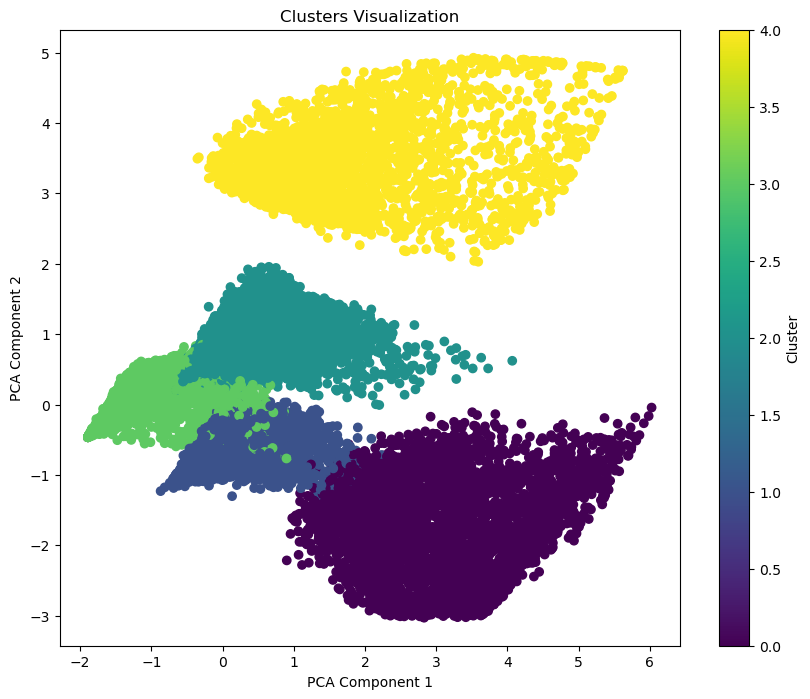

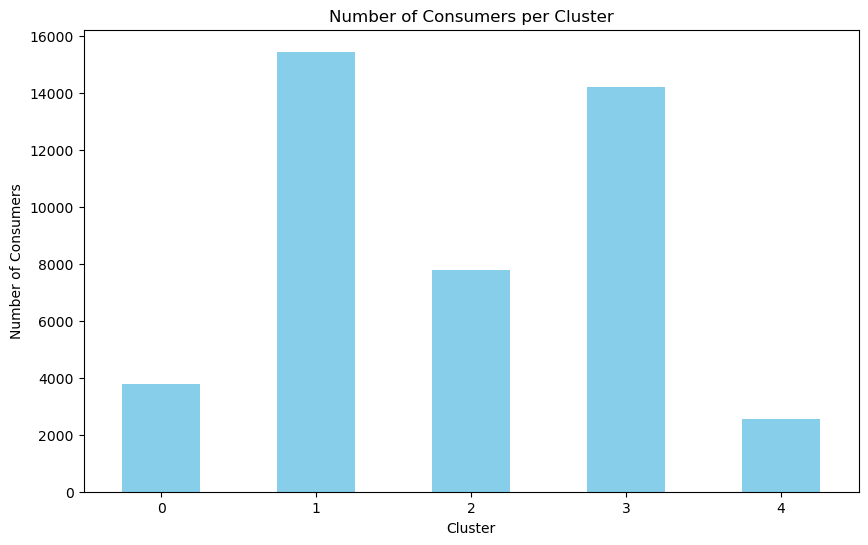

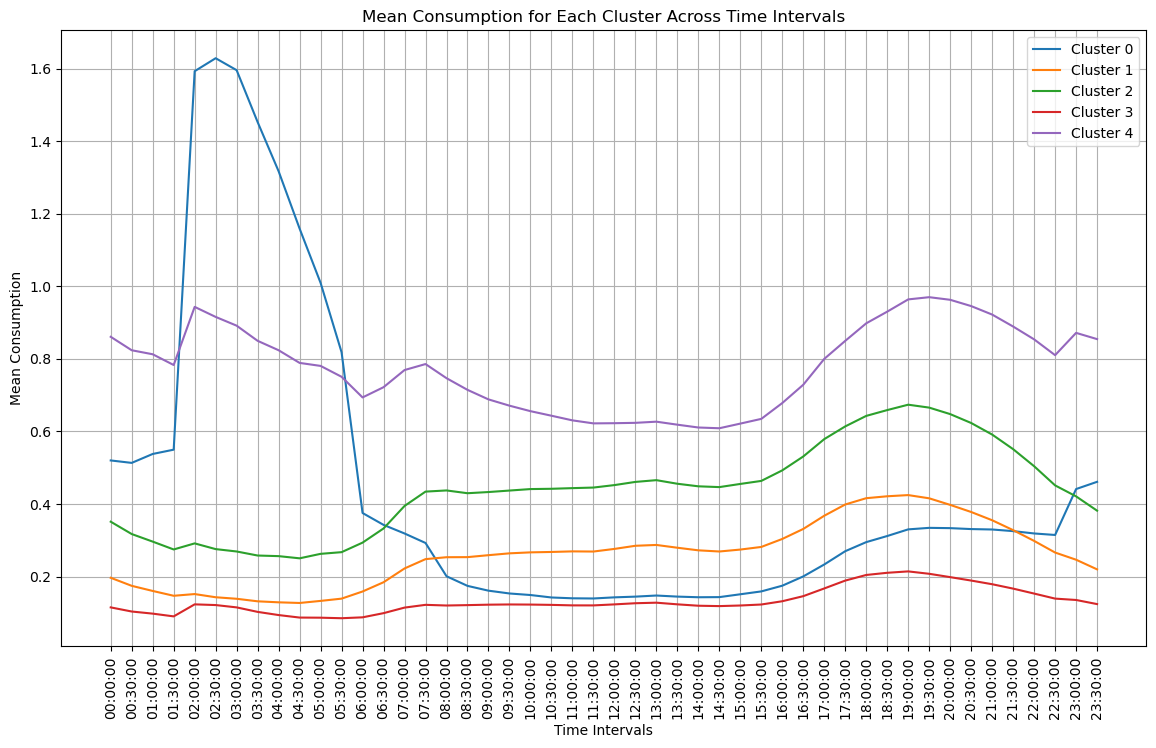

          Size  mean of daily kW  mean of hourly kW
Cluster                                            
0         3763         21.464693           0.894362
1        15441         12.480593           0.520025
2         7767         21.011086           0.875462
3        14188          6.355644           0.264818
4         2540         37.262812           1.552617
         0 - 1:59  2 - 3:59  4 - 5:59  6 - 7:59  8 - 9:59  10 - 11:59  12 - 13:59  14 - 15:59  16 - 17:59  18 - 19:59  20 - 21:59  22 - 23:59
Cluster                                                                                                                                      
0        0.530230  1.567468  1.075937  0.332221  0.172411    0.142768    0.144950    0.149131    0.219592    0.317724    0.329811    0.383930
1        0.169605  0.141304  0.132048  0.203366  0.257432    0.268205    0.281887    0.274340    0.350291    0.419359    0.364656    0.257654
2        0.309840  0.273540  0.259095  0.363690  0.434251    0.44300

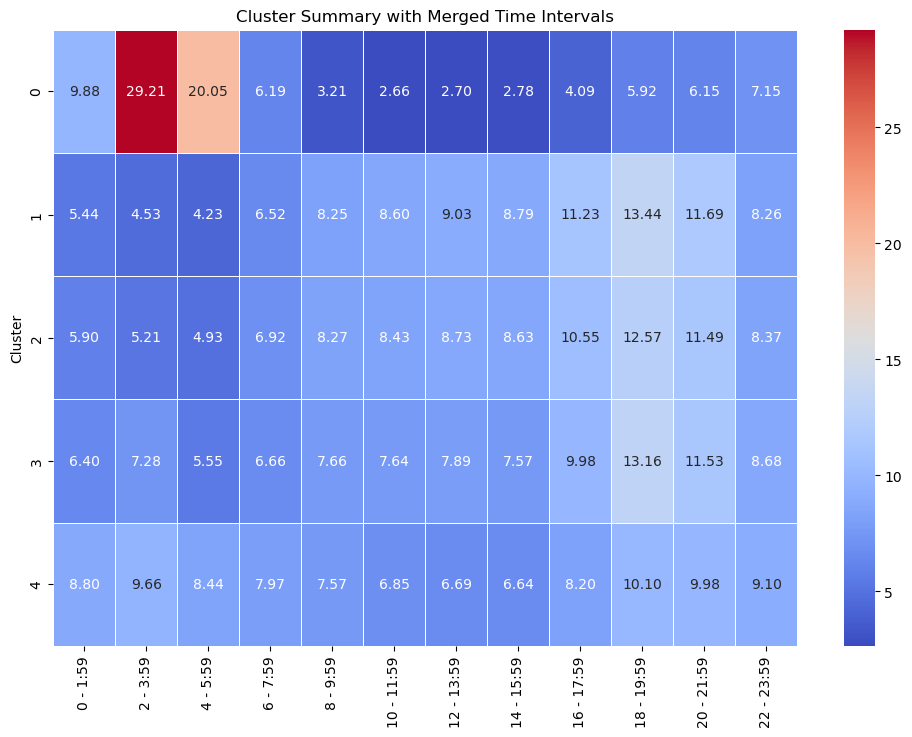

            Night   Midnight   Morning    Midday  Afternoon   Evening
Cluster                                                              
0        2.710672  13.069687  1.865166  1.320576   1.497452  2.768112
1        1.910353   1.930644  1.579204  2.443822   2.666424  3.574416
2        3.251638   3.663420  2.754723  4.020643   4.338170  5.696007
3        1.012484   1.309375  0.787132  1.109032   1.177872  1.758911
4        6.061980  10.717922  5.120144  5.784338   5.928130  8.241991


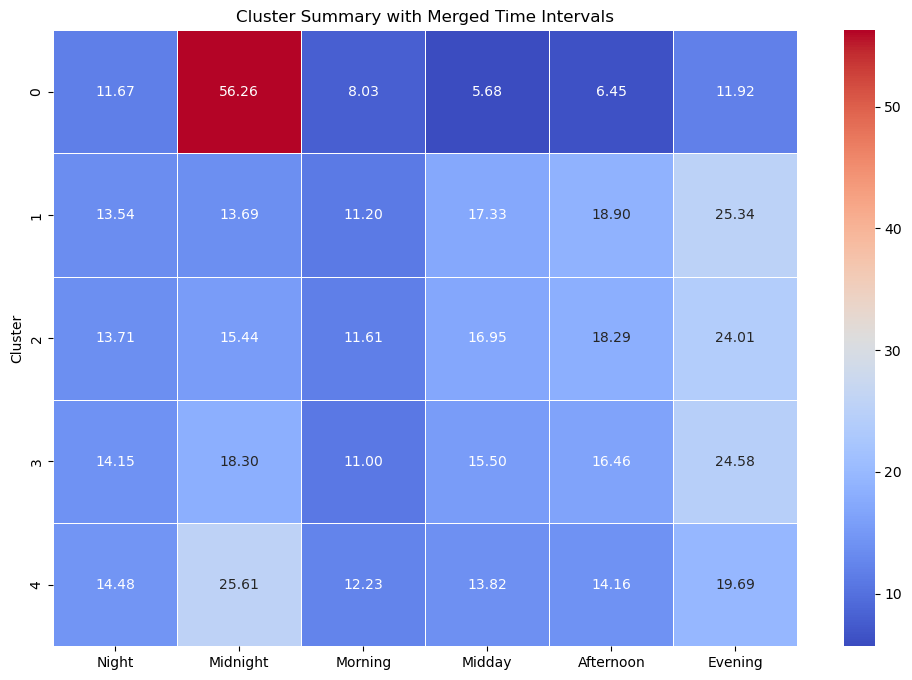

In [23]:
clustered_data = cluster(data_capped, KMeans, n_clusters=5, random_state=42, n_init=10)
hours = 2
method = "mean"
clusterDataResults(clustered_data, hours, method)

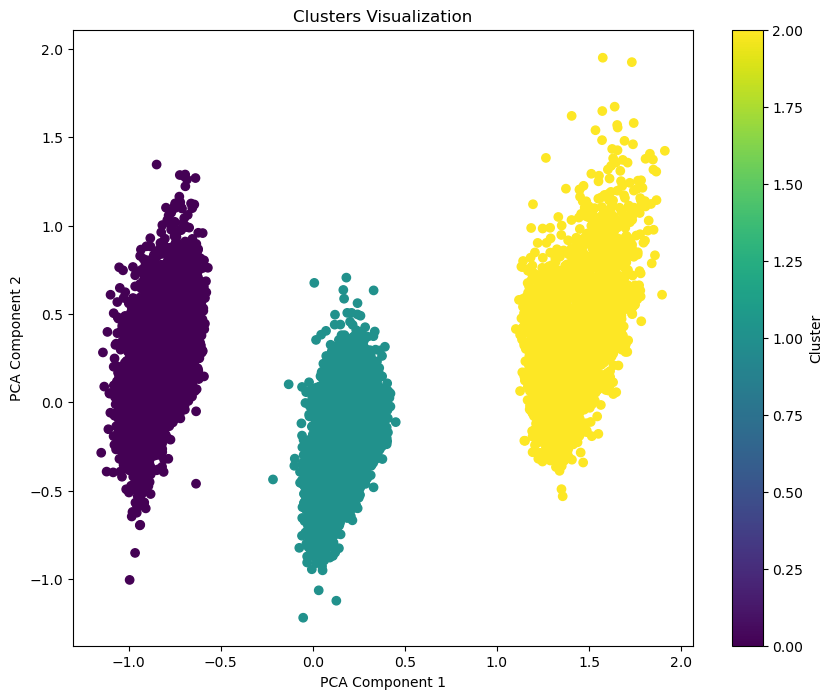

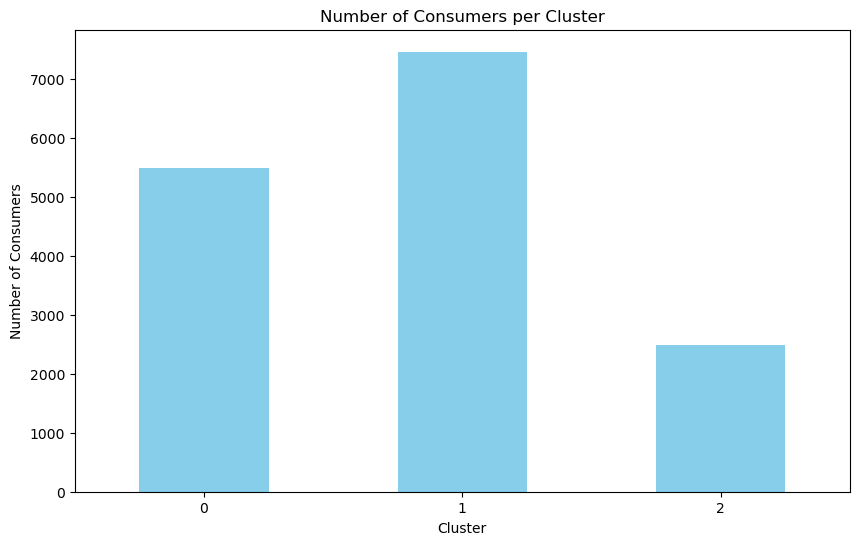

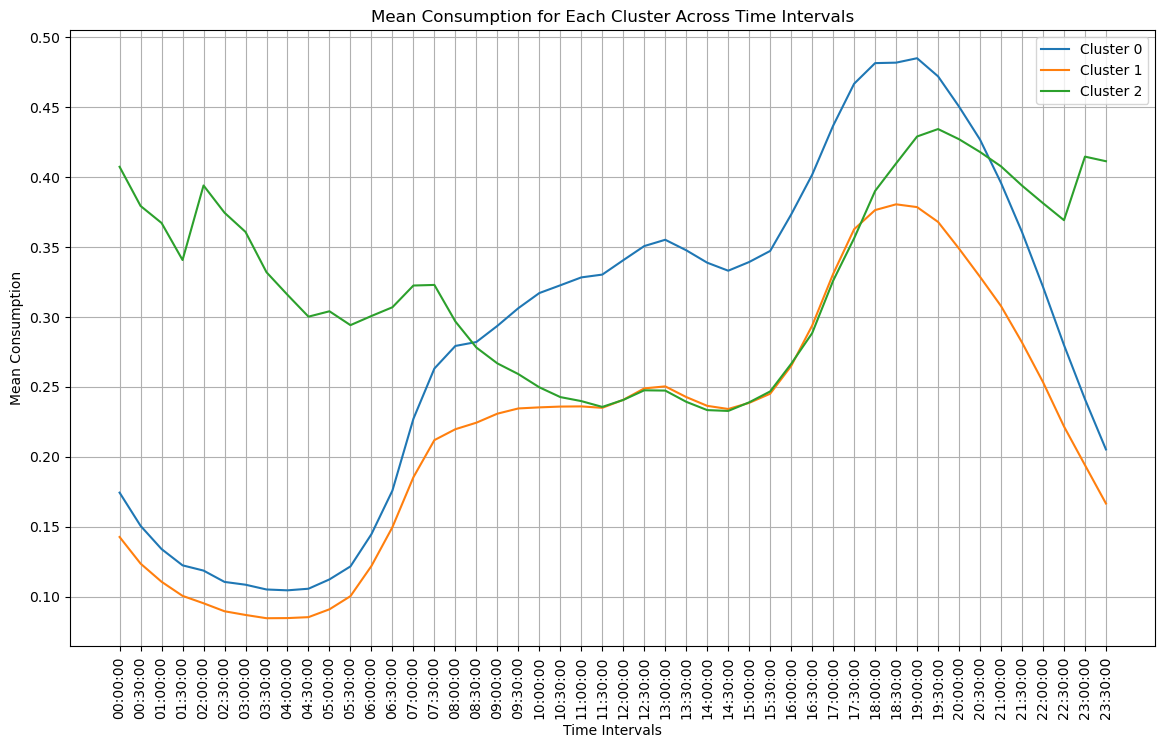

         Avg daily kW  Avg hourly kW  Size
Cluster                                   
0           13.770650       0.573777  5486
1           10.509502       0.437896  7462
2           15.541576       0.647566  2493
         0 - 2:59  3 - 5:59  6 - 8:59  9 - 11:59  12 - 14:59  15 - 17:59  18 - 20:59  21 - 23:59
Cluster                                                                                         
0        0.135033  0.109565  0.228656   0.316351    0.344327    0.394162    0.466288    0.300726
1        0.110318  0.088725  0.185461   0.234587    0.242194    0.289289    0.363491    0.237520
2        0.377197  0.317824  0.304631   0.248943    0.240147    0.287097    0.418060    0.396363
         0 - 2:59  3 - 5:59  6 - 8:59  9 - 11:59  12 - 14:59  15 - 17:59  18 - 20:59  21 - 23:59
Cluster                                                                                         
0            5.88      4.77      9.96      13.78       15.00       17.17       20.32       13.10
1        

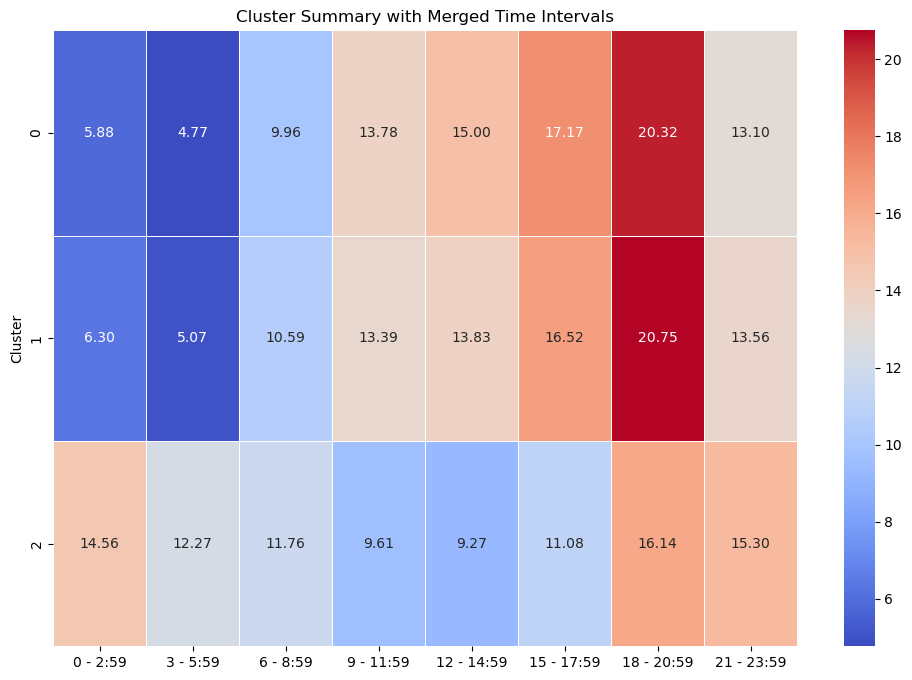

            Night  Midnight   Morning    Midday  Afternoon   Evening
Cluster                                                             
0        1.978677  1.612197  1.665531  2.944541   3.272888  4.097161
1        1.567725  1.316118  1.343559  2.147425   2.336598  3.182162
2        2.785549  4.470791  2.094564  2.229129   2.319089  3.598168
         Night  Midnight  Morning  Midday  Afternoon  Evening
Cluster                                                      
0        12.71     10.35    10.70   18.91      21.02    26.31
1        13.18     11.07    11.30   18.06      19.65    26.76
2        15.92     25.55    11.97   12.74      13.25    20.56


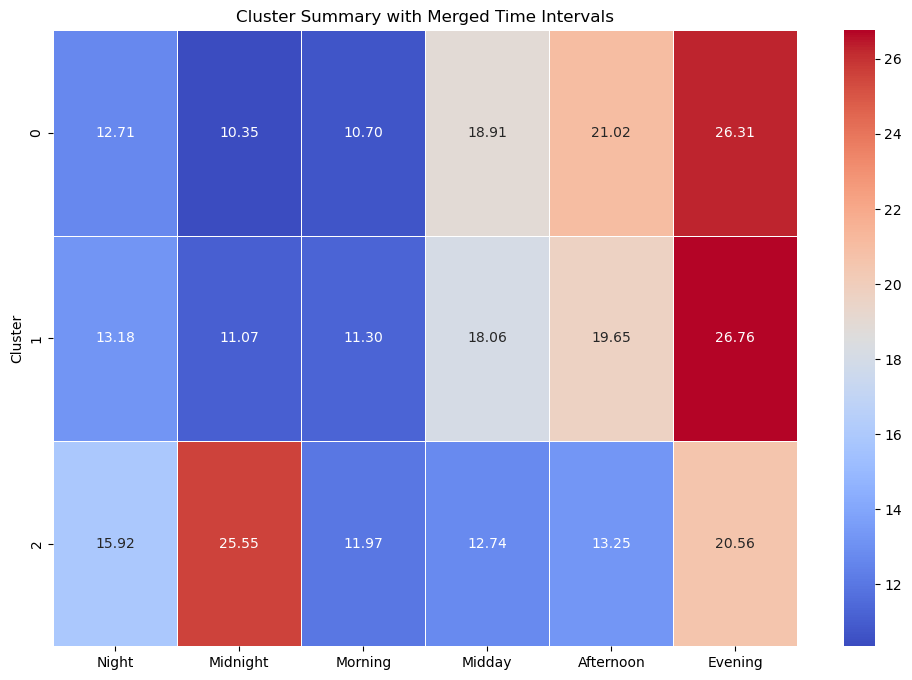

In [32]:
sub_cluster_1 = cluster(clustered_data[clustered_data["Cluster"] == 1], KMeans, n_clusters=3, random_state=42, n_init=10)
clusterDataResults(sub_cluster_1)

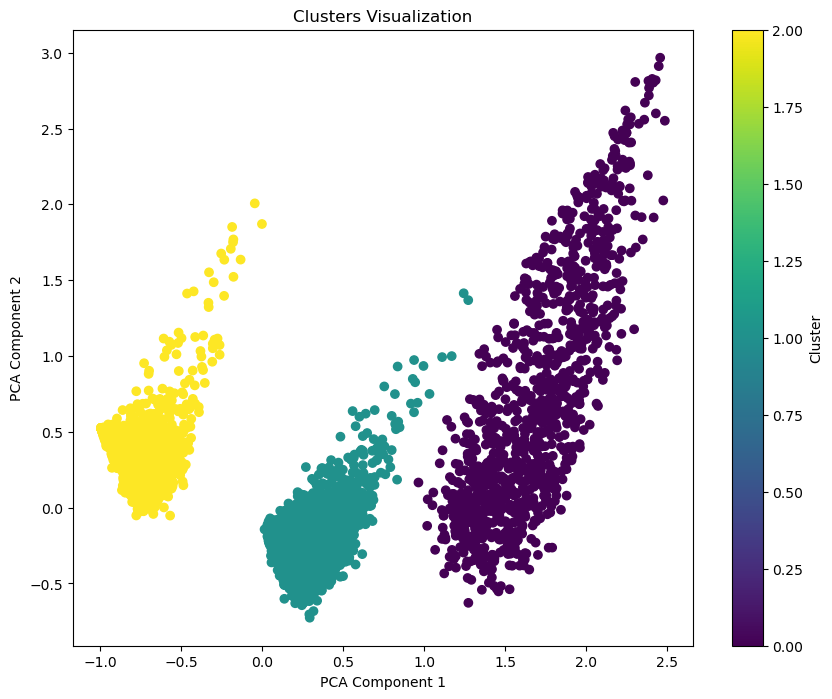

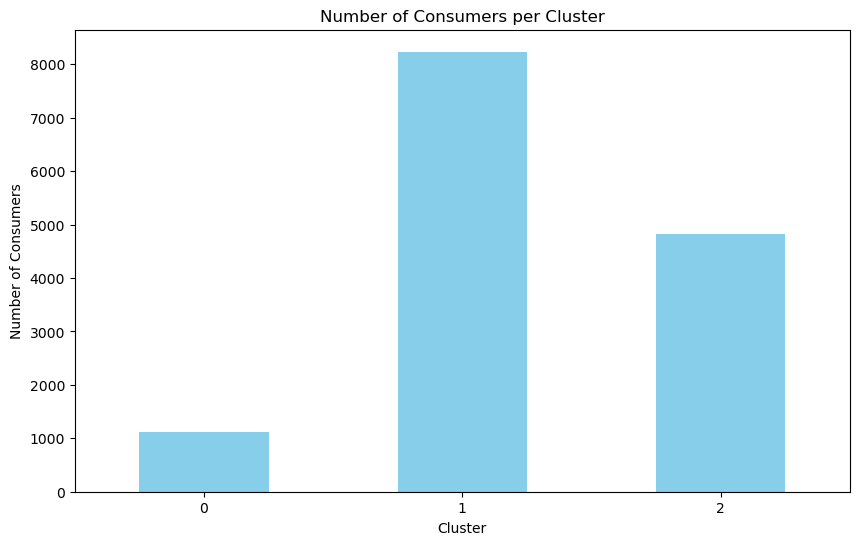

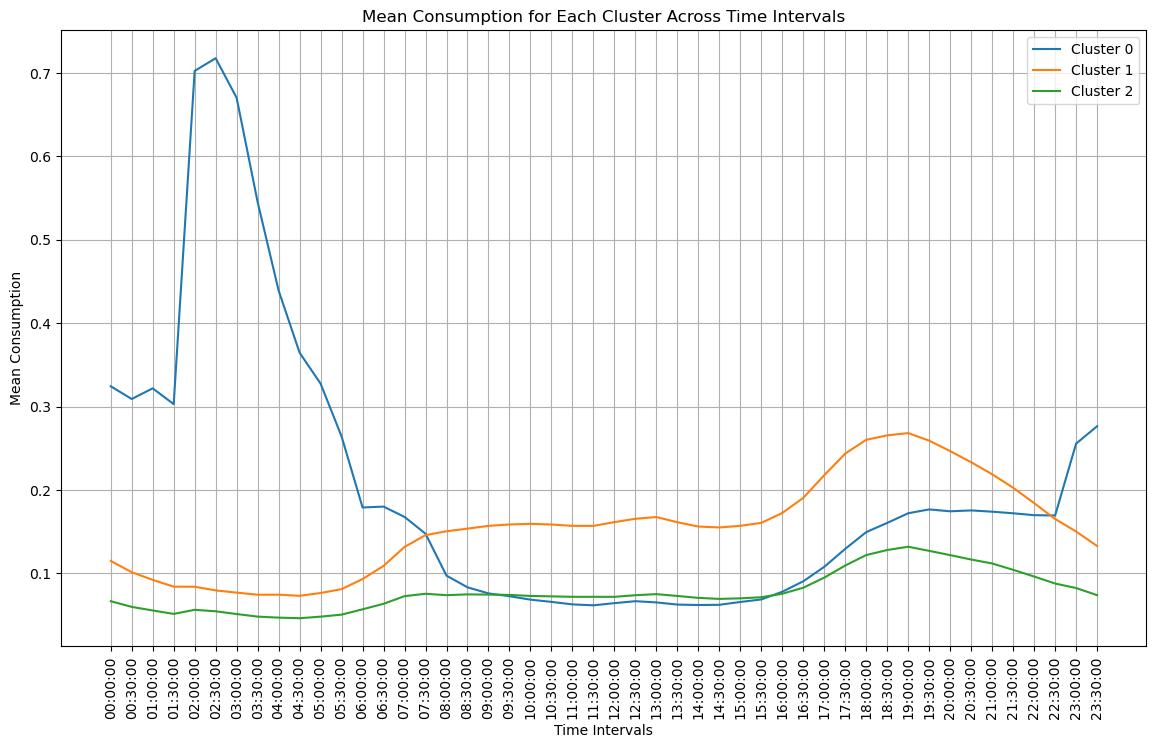

         Avg daily kW  Avg hourly kW  Size
Cluster                                   
0            9.700676       0.404195  1120
1            7.439752       0.309990  8236
2            3.732474       0.155520  4832
         0 - 2:59  3 - 5:59  6 - 8:59  9 - 11:59  12 - 14:59  15 - 17:59  18 - 20:59  21 - 23:59
Cluster                                                                                         
0        0.446386  0.435148  0.142483   0.067898    0.063851    0.090031    0.168115    0.202867
1        0.092694  0.076077  0.130645   0.157915    0.161170    0.190318    0.255465    0.175675
2        0.057373  0.048537  0.069556   0.072984    0.072289    0.084026    0.124568    0.092745
         0 - 2:59  3 - 5:59  6 - 8:59  9 - 11:59  12 - 14:59  15 - 17:59  18 - 20:59  21 - 23:59
Cluster                                                                                         
0           27.61     26.91      8.81       4.20        3.95        5.57       10.40       12.55
1        

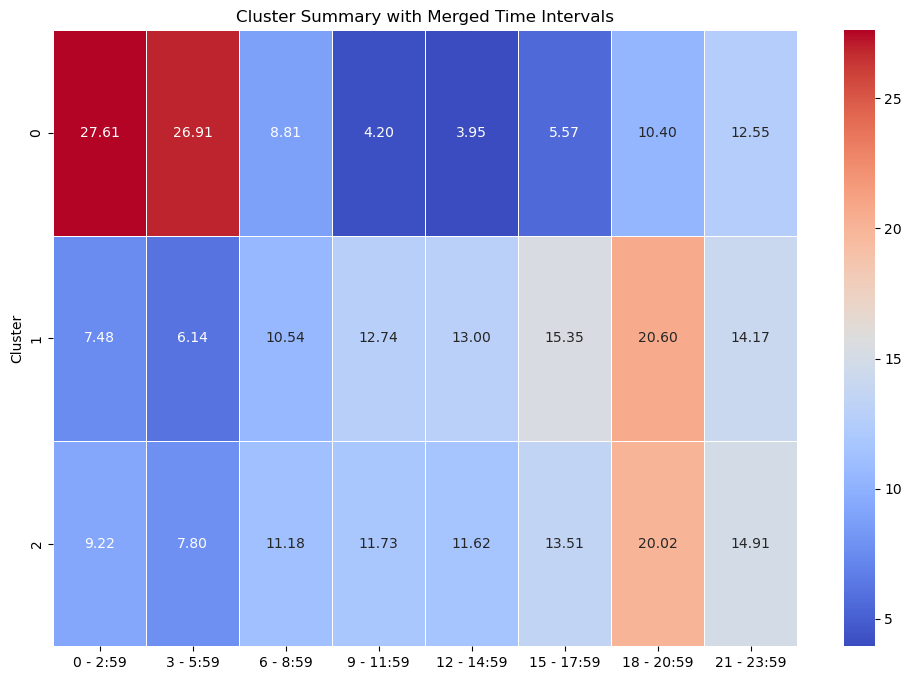

            Night  Midnight   Morning    Midday  Afternoon   Evening
Cluster                                                             
0        1.541555  5.468224  0.930871  0.603526   0.662917  1.419912
1        1.168978  1.105808  0.940808  1.441981   1.538367  2.212946
2        0.623112  0.692376  0.491878  0.658701   0.682779  1.063597
         Night  Midnight  Morning  Midday  Afternoon  Evening
Cluster                                                      
0        14.51     51.46     8.76    5.68       6.24    13.36
1        13.90     13.15    11.19   17.15      18.29    26.32
2        14.79     16.44    11.68   15.64      16.21    25.25


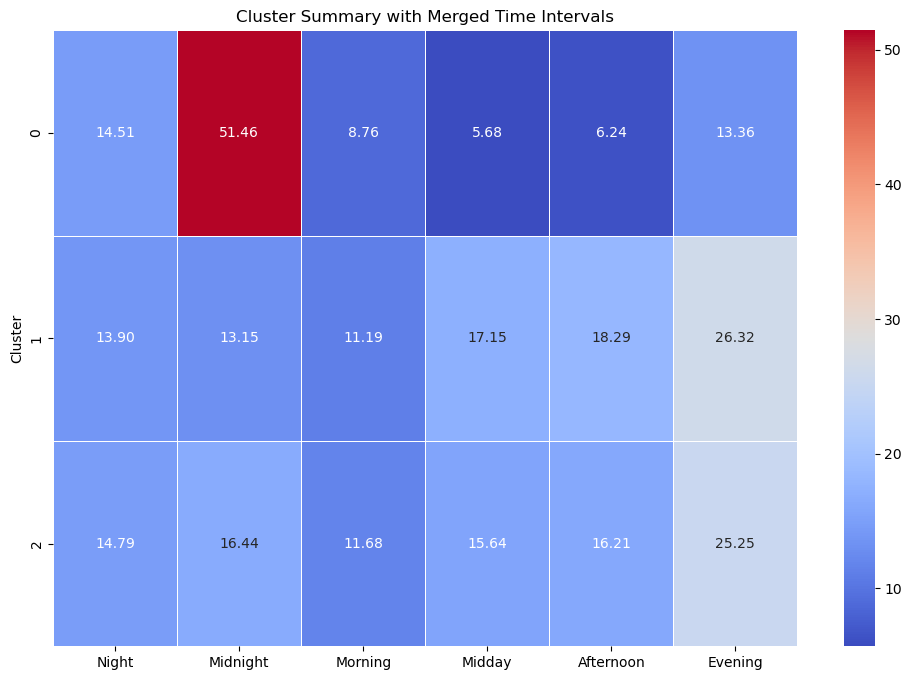

In [33]:
sub_cluster_3 = cluster(clustered_data[clustered_data["Cluster"] == 3], KMeans, n_clusters=3, random_state=42, n_init=10)
clusterDataResults(sub_cluster_3)

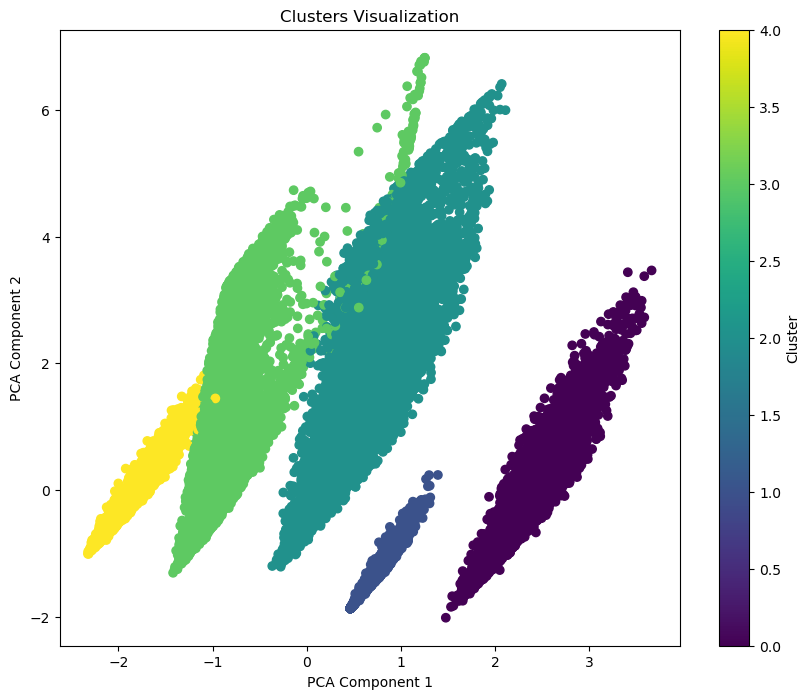

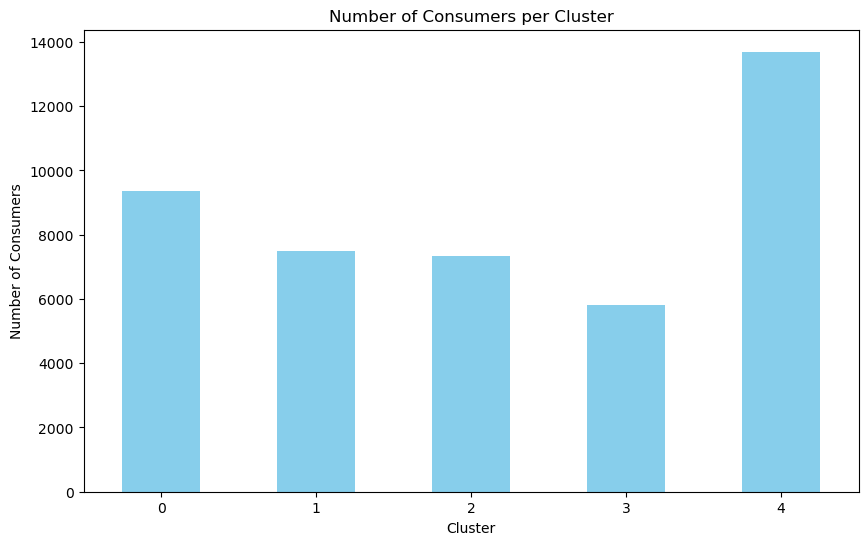

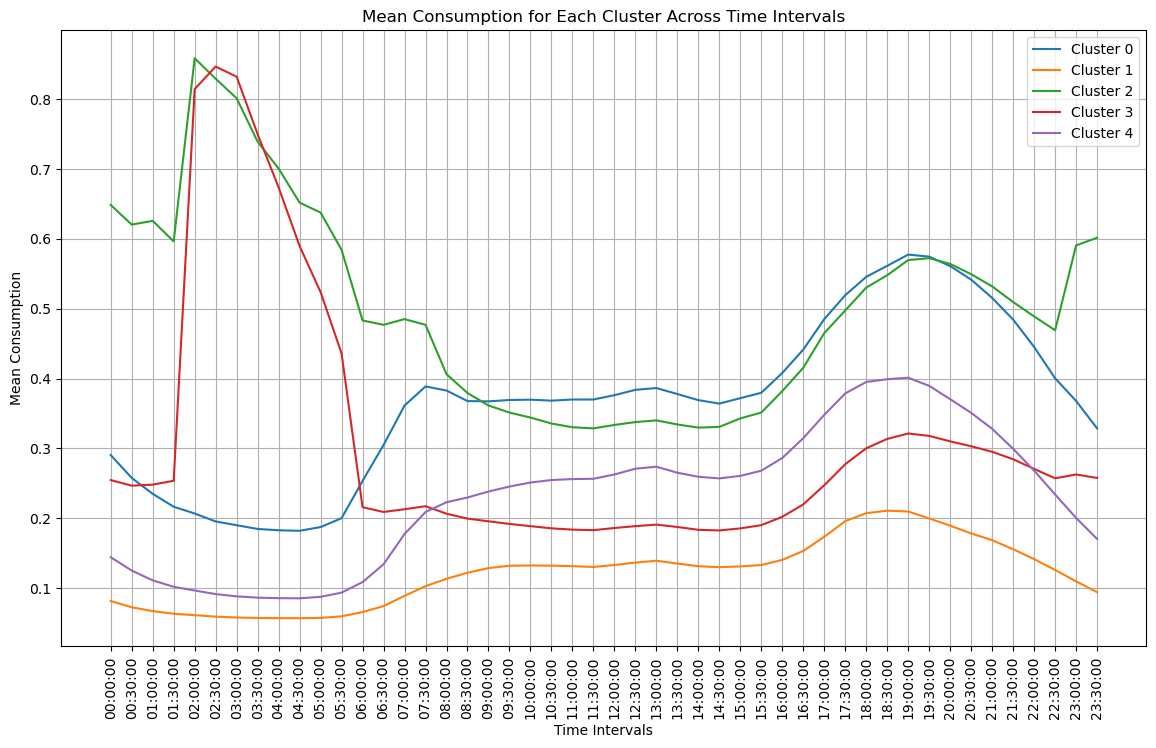

          Size  mean of daily kW  mean of hourly kW
Cluster                                            
0         9366         17.568694           0.732029
1         7493          5.825743           0.242739
2         7330         24.038523           1.001605
3         5815         14.792765           0.616365
4        13695         11.031472           0.459645
         0 - 1:59  2 - 3:59  4 - 5:59  6 - 7:59  8 - 9:59  10 - 11:59  12 - 13:59  14 - 15:59  16 - 17:59  18 - 19:59  20 - 21:59  22 - 23:59
Cluster                                                                                                                                      
0        0.249889  0.194201  0.188040  0.327071  0.371809    0.369512    0.381059    0.371201    0.463475    0.564750    0.525626    0.385538
1        0.071051  0.058875  0.057642  0.082858  0.123953    0.131515    0.135935    0.131312    0.165695    0.206838    0.172960    0.117802
2        0.622769  0.807093  0.643602  0.480533  0.374561    0.33465

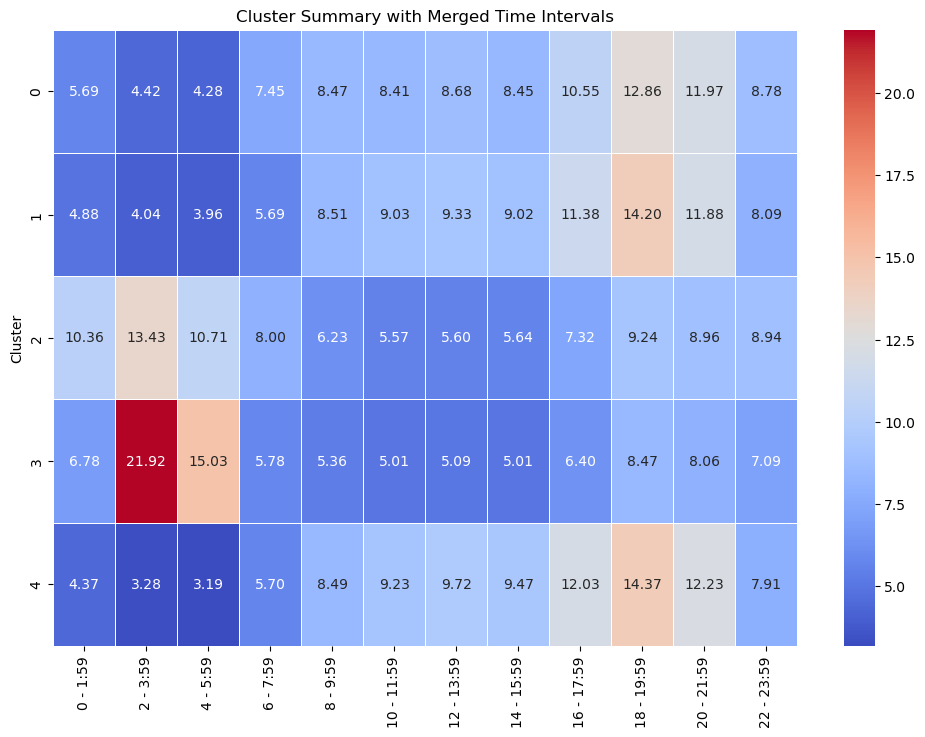

            Night  Midnight   Morning    Midday  Afternoon   Evening
Cluster                                                             
0        2.832449  2.781969  2.426217  3.361107   3.583564  4.881528
1        0.876830  0.815918  0.695263  1.195279   1.266401  1.732814
2        3.840158  8.777029  3.069098  3.062659   3.291651  4.828037
3        1.882369  6.684998  1.456395  1.693696   1.788820  2.685694
4        1.644607  1.304749  1.319683  2.309266   2.532912  3.360989


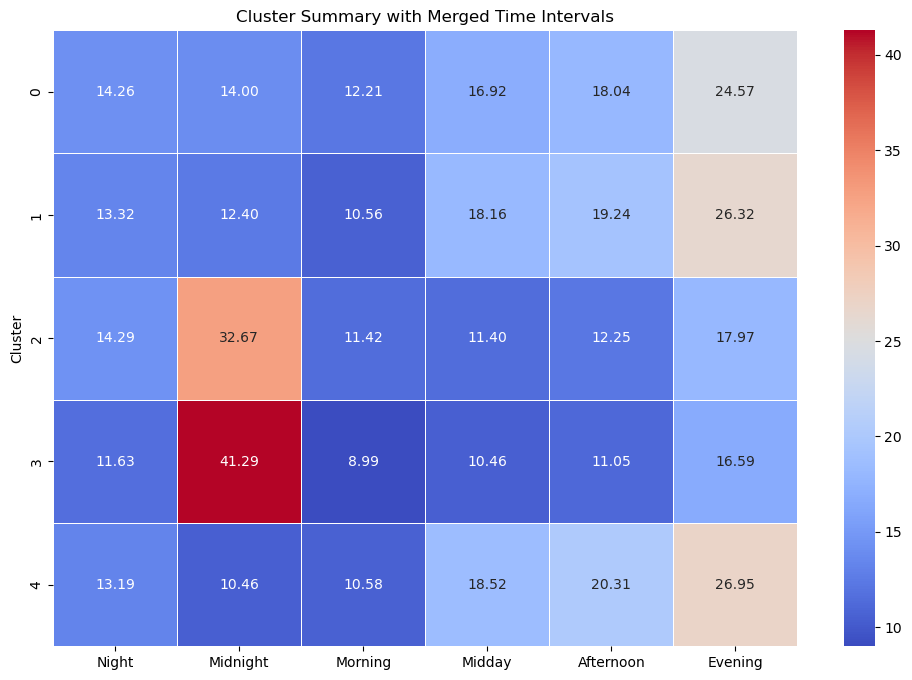

In [24]:
gmm_clustered_data = cluster(data_capped, GaussianMixture, n_components=5, covariance_type='full', random_state = 42)
hours = 2
method = "mean"
clusterDataResults(gmm_clustered_data, hours, method)